In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import warnings as wg
wg.filterwarnings("ignore")
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [3]:
text = open('/content/1661-0.txt', encoding="utf8").read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [4]:

character = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))

print(f'unique chars: {len(character)}')

unique chars: 73


In [5]:
#chunk 40 characters with 3 sequences
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len ])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [7]:
X = np.zeros((len(sentences), seq_len, len(character)), dtype=bool) # Use the built-in bool
y = np.zeros((len(sentences), len(character)), dtype=bool) # Use the built-in bool
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]

'e'

In [8]:
#one hot encoded data
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [9]:
#one hot encoded data
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [10]:
X.shape

(193950, 40, 73)

In [11]:
y.shape

(193950, 73)

In [12]:
model = Sequential()
model.add(LSTM(500, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 500)                 │       1,148,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 73)                  │          36,573 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 73)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,184,573 (4.52 MB)

 Trainable params: 1,184,573 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01,
                    batch_size=128,
                    epochs=2,
                    shuffle=True).history

Epoch 1/2
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1414s 941ms/step - accuracy: 0.2928 - loss: 2.6420 - val_accuracy: 0.3639 - val_loss: 2.3011
Epoch 2/2
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 1458s 938ms/step - accuracy: 0.4877 - loss: 1.7096 - val_accuracy: 0.4263 - val_loss: 2.0684


In [15]:
model.save('Downloads/nextword.h5')
pickle.dump(history, open("history.p", "wb"))

In [16]:
model = load_model('Downloads/nextword.h5')
history = pickle.load(open("history.p", "rb"))

In [17]:
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 ━━━━━━━━━━━━━━━━━━━━ 695s 115ms/step - accuracy: 0.5314 - loss: 1.5579
Test Loss 1.5472252368927002
Test Accuracy 0.5344985723495483


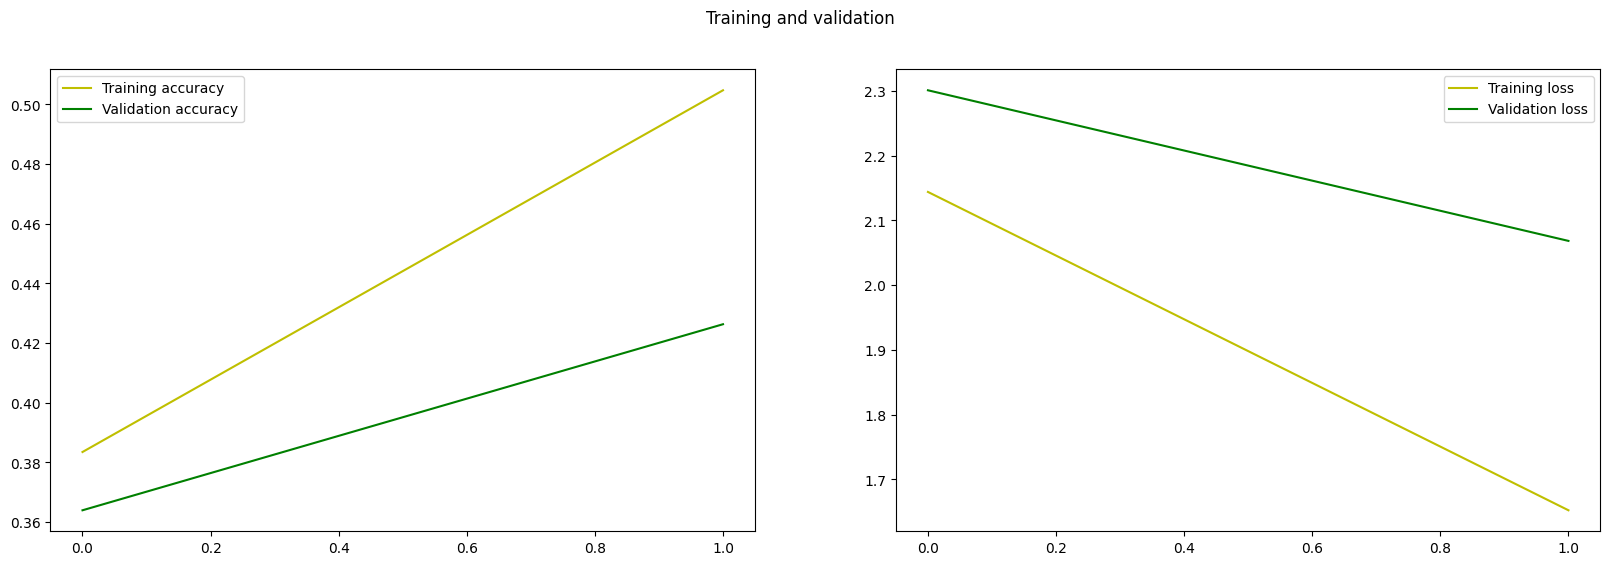

In [18]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

In [19]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.

    return x

prepare_input("This is an example of input of our model".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [20]:
#functions to get next probable characters
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [21]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [22]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [23]:
quotes = [
    "It is not a lack of  love, but a  lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN)is a type of artificial neural network which uses sequential data or time series data.",
    "Machine learning is the science of getting computers to act without being explicitly programmed.",
    "Deep learning is subset of machine learning,which is essentially a neural network with three or more layers.",
    "The goal of AI is to  make a  compter like humans to solve complex problems.",
    "Statistics are defined as numerical data, and is the field of math that deals with the collection, tabulation and interpretation of numerical data."
    ]

In [24]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of  love, but a  lack o
['f ', 'n ', 'ut ', 'pen ', 'ver ']

recurrent neural network (rnn)is a type 
['that ', 'and ', 'of ', 'had ', 'my ']

machine learning is the science of getti
['ng ', 'c ', 'on ', 'es ', 'l ']

deep learning is subset of machine learn
[' and ', 'er ', 'y ', '. ', ', ']

the goal of ai is to  make a  compter li
['ttle ', 'nd ', 'ght ', 'fe ', 'ke ']

statistics are defined as numerical data
['r ', 'ble ', 'nt ', 'ins ', 'ct ']

